In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from jax import jit
import optax
import numpy as np

from flax.training.train_state import TrainState
from pncbf.networks.mlp import MLP
from pncbf.networks.ncbf import SingleValueFn
from pncbf.networks.optim import get_default_tx

import matplotlib.pyplot as plt

import dill
from pncbf.dyn.segway import Segway

In [20]:
class MultViewAttentionCBF(nn.Module):

    hidden_dim: int = 256
    num_heads: int = 4
    dropout_rate: float = 0.05
    
    def setup(self):
        self.position_view = nn.Dense(self.hidden_dim, name='position_view')      # [p, theta]
        self.velocity_view = nn.Dense(self.hidden_dim, name='velocity_view')      # [v, omega]  
        self.safety_view = nn.Dense(self.hidden_dim, name='safety_view')          # [theta, omega]
        self.full_state_view = nn.Dense(self.hidden_dim, name='full_state_view')  # [p, theta, v, omega]
        
        # additional views
        self.position_coupling_view = nn.Dense(self.hidden_dim, name='pos_coupling')  # pos-vel coupling
        self.angle_coupling_view = nn.Dense(self.hidden_dim, name='angle_coupling')   # angle-angular vel coupling
        
        self.self_attention = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.hidden_dim, # W_q = W_k = W_v = [256, 256]
            dropout_rate=self.dropout_rate,
            decode=False
        )
        
        self.layer_norm = nn.LayerNorm()
        
        self.output_net = nn.Sequential([
            nn.Dense(self.hidden_dim),
            nn.tanh,
            nn.Dense(self.hidden_dim // 2),
            nn.tanh,
            nn.Dense(1)
        ])
        
        self.dropout = nn.Dropout(self.dropout_rate)
    
    def __call__(self, x, training: bool = True):
        
        # x shape: [batch_size, 4] for [p, theta, v, omega]

        batch_size = x.shape[0]
        
        position_state = x[:, :2]   # [p, theta]
        velocity_state = x[:, 2:]   # [v, omega]
        
        views = []
        
        # pos persective
        pos_view = self.position_view(position_state)
        views.append(nn.tanh(pos_view))
        
        # vel perspective
        vel_view = self.velocity_view(velocity_state)
        views.append(nn.tanh(vel_view))
        
        # safety perspective
        safety_features = jnp.concatenate([
            x[:, 1:2],  # theta 
            x[:, 3:4],  # omega 
        ], axis=1)

        safety_view = self.safety_view(safety_features)
        views.append(nn.tanh(safety_view))
        
        # full state persepctive
        full_view = self.full_state_view(x)
        views.append(nn.tanh(full_view))
        
        # pos-vel coupling
        pos_vel_coupling = jnp.concatenate([
            x[:, 0:1],  # p
            x[:, 2:3],  # v
        ], axis=1)
        coupling_view = self.position_coupling_view(pos_vel_coupling)
        views.append(nn.relu(coupling_view))
        
        # angle-angular vel coupling
        angle_coupling_features = jnp.concatenate([
            x[:, 1:2],  # theta
            x[:, 3:4],  # omega
        ], axis=1)
        angle_coupling_view = self.angle_coupling_view(angle_coupling_features)
        views.append(nn.relu(angle_coupling_view))
        
        # stacked views: [batch_size, num_views, hidden_dim]
        view_stack = jnp.stack(views, axis=1)
        
        # Apply layer normalization
        view_stack = self.layer_norm(view_stack)
        
        attended_views = self.self_attention(
            inputs_q=view_stack,
            inputs_kv=view_stack,
            deterministic=not training
        )
        
        # residual connection
        attended_views = attended_views + view_stack
        
        # dropout during training
        if training:
            attended_views = self.dropout(attended_views, deterministic=False)
        
        # avergae the attended views 
        aggregated = jnp.mean(attended_views, axis=1)  # [batch_size, hidden_dim]
        
        output = self.output_net(aggregated)
        return output

In [21]:
class MultiAttentionValueFn(nn.Module):
    hidden_dim: int = 256 
    num_heads: int = 4
    dropout_rate: float = 0.05
    
    def setup(self):
        self.attention_net = MultViewAttentionCBF(
            hidden_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout_rate=self.dropout_rate
        )
    
    def __call__(self, x, training: bool = True):
        result = self.attention_net(x, training=training)
        return result.squeeze(-1)

In [22]:
def multiview_attention_cbf():

    return MultiAttentionValueFn(
        hidden_dim=256,
        num_heads=4,      # 6 views, so 256/4 = 64 per head
        dropout_rate=0.05
    )

### Training

In [23]:
def get_scheduled_optimizer(initial_lr=1e-3):
    
    lr_schedule = optax.piecewise_constant_schedule(
        init_value=initial_lr,
        # boundaries_and_scales={
        #     200: 0.5,   
        #     500: 0.2,   
        #     800: 0.5,    
        # }
        boundaries_and_scales={
            100: 0.7,    
            300: 0.5,    #  0.7 * 0.5 = 0.35 
            600: 0.3,    # 0.35 * 0.3 = 0.105
            900: 0.1,    # 0.105 * 0.1 = 0.0105
        }
    )
    
    return optax.adamw(learning_rate=lr_schedule)

In [24]:
@jit
def pncbf_loss_fn(predicted_values, target_values):

    loss = jnp.mean(jnp.square(predicted_values - target_values))

    return loss

In [26]:
def train_pncbf_scheduled(states, max_violations, network, 
                         initial_lr=1e-3, batch_size=128, epochs=1000):
    
    key = jax.random.PRNGKey(42)
    dummy_input = states[0:1]
    
    # init with rng keys for attention + dropout
    init_rngs = {
        'params': key,
        'dropout': jax.random.PRNGKey(0)
    }
    params = network.init(init_rngs, dummy_input)

    tx = get_scheduled_optimizer(initial_lr)

    state = TrainState.create(
        apply_fn=network.apply,
        params=params,
        tx=tx
    )
    def get_current_lr(epoch):
        # if epoch < 200:
        #     return initial_lr
        # elif epoch < 500:
        #     return initial_lr * 0.5
        # elif epoch < 800:
        #     return initial_lr * 0.1
        # else:
        #     return initial_lr * 0.05
        if epoch < 100:
            return initial_lr
        elif epoch < 300:
            return initial_lr * 0.7
        elif epoch < 600:
            return initial_lr * 0.7 * 0.5
        elif epoch < 900:
            return initial_lr * 0.7 * 0.5 * 0.3
        else:
            return initial_lr * 0.7 * 0.5 * 0.3 * 0.1
        
    @jit
    def train_step(state, batch_states, batch_values, dropout_rng):
        def loss_fn(params):
            predicted_values = state.apply_fn(
                params, 
                batch_states,
                training=True,
                rngs={'dropout': dropout_rng}
            )
            return pncbf_loss_fn(predicted_values, batch_values)
        
        grad_fn = jax.value_and_grad(loss_fn) 
        loss, grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    losses = []
    n_samples = len(states)
    steps_per_epoch = n_samples // batch_size 

    for epoch in range(epochs):
        perm = jax.random.permutation(key, n_samples)
        key, dropout_key = jax.random.split(key)

        epoch_losses = []
        for step in range(steps_per_epoch):
            batch_indices = perm[step * batch_size:(step + 1) * batch_size]
            batch_states = states[batch_indices]
            batch_values = max_violations[batch_indices]

            dropout_key, batch_dropout_key = jax.random.split(dropout_key)
            state, loss = train_step(state, batch_states, batch_values, batch_dropout_key)
            epoch_losses.append(loss)

        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)

        if epoch % 100 == 0:
            current_lr = get_current_lr(epoch)
            print(f"epoch {epoch}, loss: {avg_loss:.6f}, lr: {current_lr:.2e}")

    return state, losses

In [27]:
print(f"JAX backend: {jax.default_backend()}")

JAX backend: gpu


### Data loading and model

In [28]:
data = np.load('segway_training_data_10k.npy', allow_pickle=True).item()
states = data['states']
max_violations = data['violations']

epoch 0, loss: 0.236423, lr: 1.00e-03
epoch 100, loss: 0.008848, lr: 7.00e-04
epoch 200, loss: 0.006591, lr: 7.00e-04
epoch 300, loss: 0.005281, lr: 3.50e-04
epoch 400, loss: 0.004634, lr: 3.50e-04
epoch 500, loss: 0.003449, lr: 3.50e-04
epoch 600, loss: 0.002983, lr: 1.05e-04
epoch 700, loss: 0.002538, lr: 1.05e-04
epoch 800, loss: 0.002453, lr: 1.05e-04
epoch 900, loss: 0.001978, lr: 1.05e-05
epoch 1000, loss: 0.001793, lr: 1.05e-05
epoch 1100, loss: 0.001608, lr: 1.05e-05


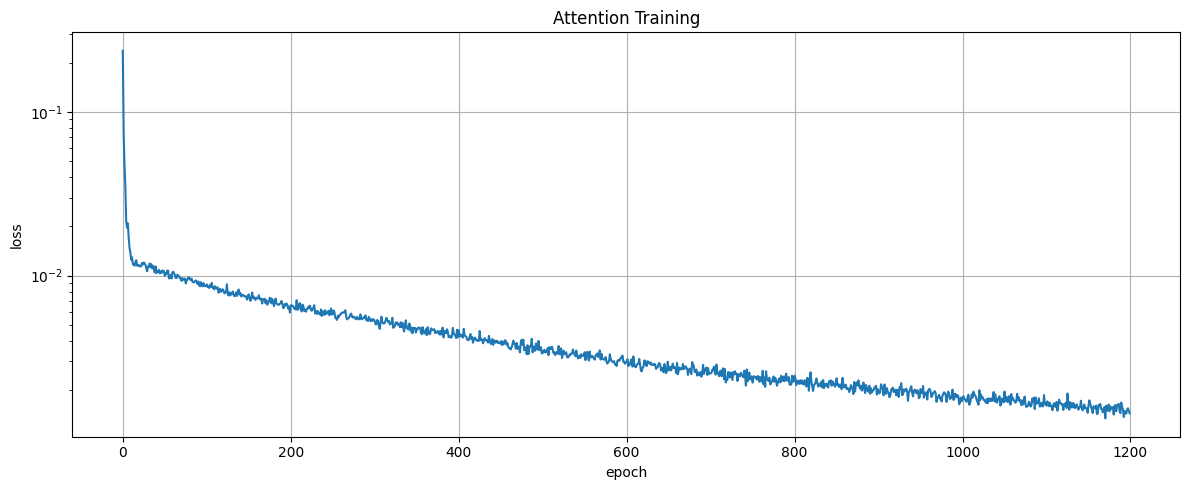

In [29]:
model = multiview_attention_cbf()

trained_state, losses = train_pncbf_scheduled(
    states, max_violations, model, 
    initial_lr=1e-3, epochs=1200
)

plt.figure(figsize=(12, 5))

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Attention Training')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
print(f"final losses: {losses[-1]:.7f}")

final losses: 0.0014441


In [34]:
np.save('segway_attn_6views_losses_best', losses)
print("losses saved!")

# with open('pncbf_model_segway_trainstate.pkl', 'wb') as f:
#     dill.dump(trained_state, f) #--> check later, could be bc of dropout()
# --> params 

params_only = trained_state.params
with open('segway_attn_6views_best.pkl', 'wb') as f:
    dill.dump(params_only, f)

print("model saved!")

losses saved!
model saved!
